# Matt and Paul's Notebook

## 1. Packages and Libraries Import

In [2]:
# Import the relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, \
recall_score,precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost
import statsmodels.api as sm
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
import time

import warnings
warnings.filterwarnings("ignore")

## 1b. Test on Iris Dataset (to be deleted)

In [3]:
# Load Iris Data to test functions
df= pd.read_csv('data/regularseason18.csv').drop('Unnamed: 0', axis = 1)

In [4]:
# Petal length and width features

X = df.drop('fav_win',axis=1)
y = df['fav_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((4157, 106), (1040, 106))

In [5]:
y.value_counts(normalize=True)

True     0.736386
False    0.263614
Name: fav_win, dtype: float64

## 2. Function Builds for Project

### 2a. Data Scaling

In [6]:
ss = StandardScaler()
X_train_scaled=ss.fit_transform(X_train)
X_test_scaled=ss.transform(X_test)

In [7]:
len(X_test_scaled)

1040

In [8]:
log_new = LogisticRegression()
selector = RFECV(log_new, min_features_to_select=10, step=1)
selector.fit(X_train_scaled,y_train)
selector.ranking_

array([ 7, 13,  1, 61, 14,  9,  1,  1,  1,  1,  1,  1, 46, 32, 11,  1,  6,
        4,  1,  1, 30, 10,  1,  8, 28,  1,  1, 29,  1, 27, 43,  1, 44, 42,
        2,  1,  3, 31,  1, 54, 36,  1,  1,  1, 35, 58,  1, 64,  1,  1,  1,
       53, 12, 33, 22, 15, 24, 48, 47, 56, 23, 18, 62, 60, 45,  1, 49, 65,
       50, 51,  1,  1,  1, 40, 38, 26, 66, 34,  1,  1, 20, 17, 16, 39,  1,
       55, 19,  1,  1,  1,  1, 25, 59,  1, 21,  1,  1,  5, 37, 52, 57,  1,
       41,  1, 63,  1])

In [9]:
new_dict = dict(zip(X_train.columns,selector.ranking_))
best_pred = [k for (k,v) in new_dict.items() if v == 1]

In [10]:
X_train_scaled=pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_train_best_log=X_train_scaled[best_pred]

In [11]:
X_test_scaled=pd.DataFrame(X_test_scaled,columns=X_test.columns)
X_test_best_log=X_test_scaled[best_pred]

In [12]:
y_train=y_train.reset_index(drop=True)

### 2b. Logistic Regression Model

Create a function to use GridSearchCV, find the best hyperparameters and then create a model with those results and values. Also print some scoring metrics to assess how well the model performs.

In [13]:
def logreg(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'penalty': ['l1', 'l2' ,'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    
    # Instantiate & fit LogReg model for GridSearch
    grid_logreg = LogisticRegression(random_state=42)
    grid_logreg.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_logreg, param_grid=grid, cv=5,
                      scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    logreg_params = gs.best_params_
    
    # Use best penalty from best_params
    logreg_penalty = logreg_params['penalty']
    print(f'Penalty: {logreg_penalty}')
    
    # Use best solver from best_params
    logreg_solver = logreg_params['solver']
    print(f'Solver: {logreg_solver}')
    
    # Instantiate & fit LogReg model
    log = LogisticRegression(random_state=42, penalty=logreg_penalty, solver=logreg_solver)
    log.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = log.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(log, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = log.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = log.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
  
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 Score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(log, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(log, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(log, X_train, y_train)
    plot_confusion_matrix(log, X_test, y_test)

Penalty: l2
Solver: newton-cg
Mean Cross-Val Score: 0.8607157733962788
Train Mean Accuracy: 0.8624007697859033
Test Mean Accuracy: 0.8394230769230769
Recall Score: 0.9177718832891246
Precision Score: 0.8682559598494354
F1 Score: 0.8923275306254028


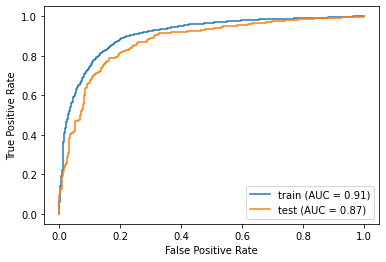

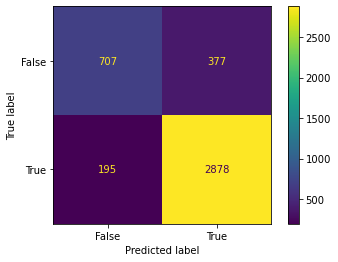

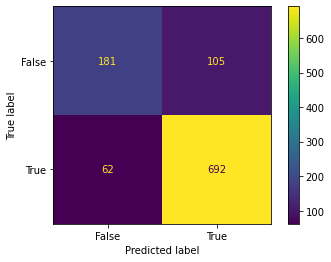

In [14]:
logreg(X_train_best_log,X_test_best_log,y_train,y_test)

### 2c. K-Nearest Neighbors Model

Create a function to use GridSearchCV, find the best hyperparameters and then create a model with those results and values. Also print some scoring metrics to assess how well the model performs.

In [32]:
def knn(X_train, X_test, y_train, y_test, metric='minkowski', cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'n_neighbors': [1,3,5,7,9,11,13,15,17,19,21,23,25],
    'metric': ['minkowski', 'manhattan'],
    'weights': ['uniform', 'distance']}
    
    # Instantiate & fit KNN model for GridSearch
    grid_knn = KNeighborsClassifier()
    grid_knn.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_knn, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    knn_params = gs.best_params_
    
    # Use best # of neighbors from best_params
    knn_neighbors = knn_params['n_neighbors']
    print(f'Number of Neighbors: {knn_neighbors}')
    
    # Use best metric from best_params
    knn_metric = knn_params['metric']
    print(f'Metric: {knn_metric}')
    
    # Use best weights from best_params
    knn_weights=knn_params['weights']
    print(f'Weights: {knn_weights}')
    
    # Instantiate & fit K-Nearest Neighbors model
    knn = KNeighborsClassifier(n_neighbors=knn_neighbors, metric=knn_metric,
                               weights=knn_weights)
    knn.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = knn.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(knn, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = knn.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = knn.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(knn, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(knn, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(knn, X_train, y_train)
    plot_confusion_matrix(knn, X_test, y_test)

Number of Neighbors: 5
Metric: manhattan
Weights: distance
Mean Cross-Val Score: 0.8390649588077386
Train Mean Accuracy: 1.0
Test Mean Accuracy: 0.8115384615384615
Recall Score: 0.9283819628647215
Precision Score: 0.831353919239905
F1 score: 0.8771929824561403


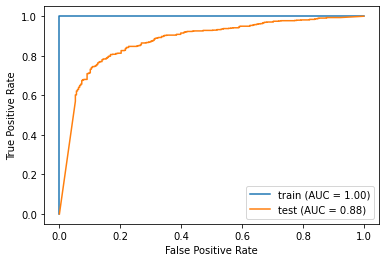

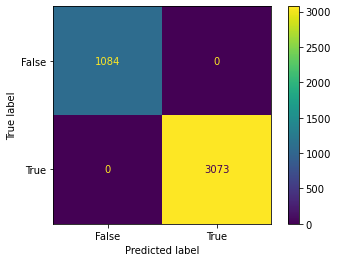

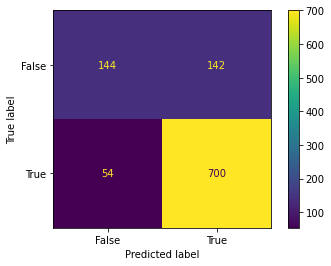

In [33]:
#Takes 6 minutes and 25 seconds to run
knn(X_train_scaled, X_test_scaled, y_train, y_test)

In [ ]:
# # GridSearchCV alternative coded by hand (not to be used)
# knn_dict={}
# for index in range(1,33,2):
#     knn_model = KNeighborsClassifier(n_neighbors=index)
#     knn_log_loss = -1 * cross_val_score(knn_model, X_train,
#                                         y_train, scoring="accuracy").mean()
#     knn_dict[index] = knn_log_loss
# min_knn = min(knn_dict.values())
# low_key = list(knn_dict.keys())[list(knn_dict.values()).index(min_knn)]
# knn = KNeighborsClassifier(n_neighbors=low_key,metric=metric)

### 2d. Decision Tree Model

In [34]:
dtree_new=DecisionTreeClassifier()
selector2 = RFECV(dtree_new, min_features_to_select=10, step=1)
selector2.fit(X_train_scaled,y_train)
selector2.ranking_

array([26,  1,  1, 40, 51, 30, 83, 85, 19, 67, 14, 15, 48, 27, 12,  1, 41,
       87, 20, 29, 90, 72, 36, 65,  5, 24,  8, 50, 47,  7,  1, 23, 70, 59,
       39, 38,  1,  4, 37, 54, 63, 18,  1, 88, 33, 60, 77, 84, 46, 21, 79,
       89, 52, 34,  3,  1, 68, 93, 91, 94, 86, 10,  6, 11, 57, 42, 61, 64,
        1,  9, 45, 53, 44, 66, 16, 56,  1, 81, 80, 25, 74, 28, 55,  1, 58,
       13, 75, 78, 73, 31, 92, 17, 76, 32,  2,  1,  1, 49, 71, 43, 22,  1,
       69, 62, 35, 82])

In [35]:
new_dict2 = dict(zip(X_train.columns,selector2.ranking_))
best_pred2 = [k for (k,v) in new_dict2.items() if v == 1]

In [36]:
X_train_best_dtree=X_train_scaled[best_pred2]
X_test_best_dtree=X_test_scaled[best_pred2]

In [214]:
best_pred2

['1FGA3',
 '1FTA',
 '1DR',
 '1Ast',
 '1TO',
 '1Opp_FGM',
 '1Opp_FGA3',
 '1Opp_OR',
 '1Opp_DR',
 '1possessions',
 '1FTR',
 '13PR',
 '1DRpct',
 '1ATOr',
 '1TO_ratio',
 '1Opp_TSpct',
 '1Opp_3PR',
 '1Opp_ORpct',
 '2TO',
 '2Blk',
 '2Opp_FGA3',
 '2Opp_DR',
 '2Opp_Stl',
 '2Blk_pct',
 '2TO_ratio',
 '2Opp_TSpct',
 '2Opp_3PR',
 '2Opp_DRpct',
 '2Opp_Stl_pct',
 '2OR',
 '2possessions',
 '2Opp_TO_ratio',
 '2Opp_TO']

Create a function to use GridSearchCV, find the best hyperparameters and then create a model with those results and values. Also print some scoring metrics to assess how well the model performs.

In [37]:
def dtree(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'max_depth': [3,10,15],
    'min_samples_split': [2,8,10,15],
    'criterion': ['gini', 'entropy']}
    
    # Instantiate & fit Decision Tree model for GridSearch
    grid_dt = DecisionTreeClassifier()
    grid_dt.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_dt, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    dt_params = gs.best_params_
    
    # Use best max depth from best_params
    dt_max_depth = dt_params['max_depth']
    print(f'Max Depth: {dt_max_depth}')
    
    # Use best minimum sample split from best_params
    dt_min_samp = dt_params['min_samples_split']
    print(f'Min Sample Split: {dt_min_samp}')
    
    # Use best criterion from best_params
    dt_criterion = dt_params['criterion']
    print(f'criterion: {dt_criterion}')
    
    # Instantiate & fit Decision Tree model
    dtree = DecisionTreeClassifier(max_depth=dt_max_depth, criterion=dt_criterion,
                                   min_samples_split=dt_min_samp, random_state=42)
    dtree.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = dtree.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(dtree, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = dtree.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = dtree.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(dtree, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(dtree, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(dtree, X_train, y_train)
    plot_confusion_matrix(dtree, X_test, y_test)

Max Depth: 10
Min Sample Split: 8
criterion: gini
Mean Cross-Val Score: 0.779644832453948
Train Mean Accuracy: 0.9437094058215059
Test Mean Accuracy: 0.7682692307692308
Recall Score: 0.8488063660477454
Precision Score: 0.834419817470665
F1 score: 0.84155161078238


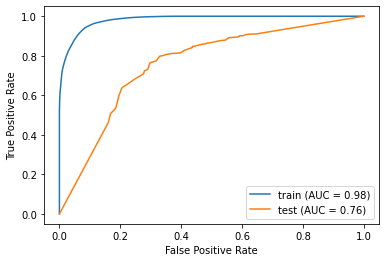

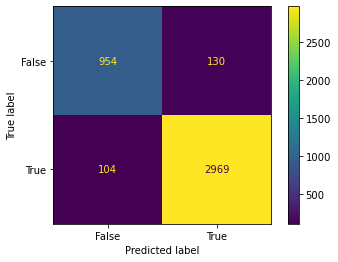

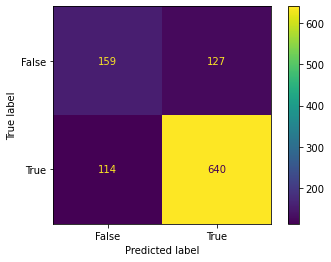

In [38]:
#Took 14 min to run
dtree(X_train_best_dtree, X_test_best_dtree, y_train, y_test)

### 2e. Random Forest Model

Create a function to use GridSearchCV, find the best hyperparameters and then create a model with those results and values. Also print some scoring metrics to assess how well the model performs.

In [ ]:
def random_forest(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'n_estimators': [75,90,100,110,115,125,150,500],
    'criterion': ['gini', 'entropy']}
    
    # Instantiate & fit Random Forest model for GridSearch
    grid_rf = RandomForestClassifier()
    grid_rf.fit(X_train,y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_rf, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    rf_params = gs.best_params_
    
    # Use best # of trees from best_params
    rf_n_estimators = rf_params['n_estimators']
    print(f'Number of Trees: {rf_n_estimators}')
    
    # Use best criterion from best_params
    rf_criterion = rf_params['criterion']
    print(f'criterion: {rf_criterion}')
    
    # Instantiate & fit Random Forest model
    rforest = RandomForestClassifier(n_estimators=rf_n_estimators, criterion=rf_criterion,
                                    random_state=42)
    rforest.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = rforest.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(rforest, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = rforest.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = rforest.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(rforest, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(rforest, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(rforest, X_train, y_train)
    plot_confusion_matrix(rforest, X_test, y_test);

Number of Trees: 110
criterion: entropy
Mean Cross-Val Score: 0.8472423748032953
Train Mean Accuracy: 1.0
Test Mean Accuracy: 0.8355769230769231
Recall Score: 0.9509283819628647
Precision Score: 0.8425381903642774
F1 score: 0.8934579439252336


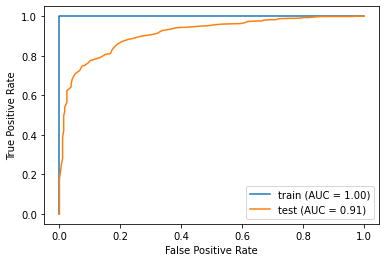

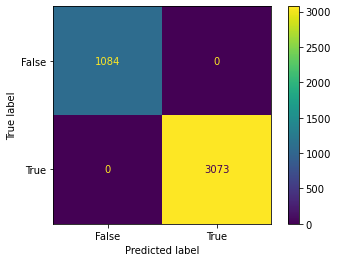

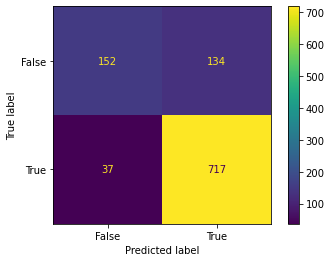

In [40]:
# Takes 1 hour and 6 minutes
random_forest(X_train, X_test, y_train, y_test, cv=5)

### 2f. Bagging Classifier Model

Create a function to use GridSearchCV, find the best hyperparameters and then create a model with those results and values. Also print some scoring metrics to assess how well the model performs.

In [41]:
def bagged(X_train, X_test, y_train, y_test, cv=5):

    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'base_estimator__max_depth': [2,5,15],
    'base_estimator__criterion': ['gini', 'entropy'],
    'max_samples': [1,2,3],
    'max_features': [1,2,3],
    'n_estimators': [10,50,100]}
    
    # Instantiate & fit Bagging Classifier model for GridSearch
    grid_bag = BaggingClassifier(DecisionTreeClassifier(), random_state=42)
    grid_bag.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_bag, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    bag_params = gs.best_params_
    
    # Use best max depth from best_params
    bag_max_depth = bag_params['base_estimator__max_depth']
    print(f'Dec Tree Max Depth: {bag_max_depth}')
    
    # Use best max depth from best_params
    bag_criterion = bag_params['base_estimator__criterion']
    print(f'Dec Tree Criterion: {bag_criterion}')
    
    # Use best max samples from best_params
    bag_max_sample = bag_params['max_samples']
    print(f'Bagging Max Samples: {bag_max_sample}')
    
    # Use best max features from best_params
    bag_max_features = bag_params['max_features']
    print(f'Bag Max Features: {bag_max_features}')
    
    # Use best max depth from best_params
    bag_estimators = bag_params['n_estimators']
    print(f'# of Base Estimators: {bag_estimators}')
    
    # Instantiate & fit Bagging Classifier model
    bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=bag_max_depth,
                                criterion=bag_criterion), max_samples=bag_max_sample,
                                max_features=bag_max_features, n_estimators=bag_estimators,
                                random_state=42)
    bagging.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = bagging.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(bagging, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = bagging.score(X_train, y_train)
    print(f'Train Mean Accuracy Score: {train_score}')
    test_score = bagging.score(X_test, y_test)
    print(f'Test Mean Accuracy Score: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(bagging, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(bagging, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(bagging, X_train, y_train)
    plot_confusion_matrix(bagging, X_test, y_test);

Dec Tree Max Depth: 2
Dec Tree Criterion: gini
Bagging Max Samples: 1
Bag Max Features: 1
# of Base Estimators: 10
Mean Cross-Val Score: 0.7392350504489493
Train Mean Accuracy Score: 0.7392350252586
Test Mean Accuracy Score: 0.725
Recall Score: 1.0
Precision Score: 0.725
F1 score: 0.8405797101449275


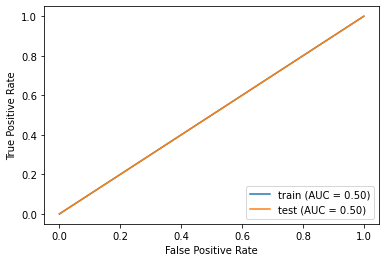

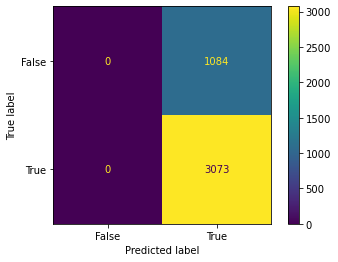

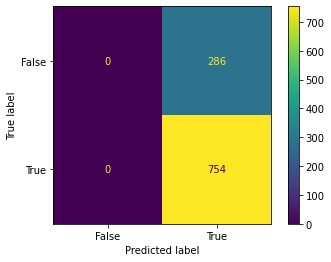

In [42]:
# Takes about 7-10 minutes to run
bagged(X_train, X_test, y_train, y_test, cv=5)

### 2g. Gradient Booster Classifier Model

In [43]:
def grad_boost(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'max_depth': [3,5,10,15],
    'min_samples_split': [2,3,5,10,15],
    'loss': ['deviance', 'exponential'],
    'learning_rate': [.01,.05,.1,.3,.5],
    'n_estimators': [100,500,1000],
    'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae']}
    
    # Instantiate & fit Bagging Classifier model for GridSearch
    grad = GradientBoostingClassifier(random_state=42)
    grad.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grad, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    grad_params = gs.best_params_
    
    # Use best max depth from best_params
    grad_max_depth = grad_params['max_depth']
    print(f'Gradient Boost Max Depth: {grad_max_depth}')
    
    # Use best minimum sample split from best_params
    grad_min_sample = grad_params['min_samples_split']
    print(f'Gradient Boost Min Sample Split: {grad_min_sample}')
    
    # Use best loss from best_params
    grad_loss = grad_params['loss']
    print(f'Gradient Boost Loss: {grad_loss}')
    
    # Use best learning rate from best_params
    grad_learning_rate = grad_params['learning_rate']
    print(f'Gradient Boost Learning Rate: {grad_learning_rate}')
    
    # Use best estimators from best_params
    grad_estimators = grad_params['n_estimators']
    print(f'Gradient Boost Estimators: {grad_estimators}')
    
    # Use best criterion from best_params
    grad_criterion = grad_params['criterion']
    print(f'# of Base Estimators: {grad_criterion}')
    
    # Instantiate & fit Gradient Booster model
    g_boost = GradientBoostingClassifier(max_depth=grad_max_depth, min_samples_split=grad_min_sample,
                                         loss=grad_loss, learning_rate=grad_learning_rate,
                                         n_estimators=grad_estimators, criterion=grad_criterion,
                                         random_state=42)
    g_boost.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = g_boost.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(g_boost, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = g_boost.score(X_train, y_train)
    print(f'Train Mean Accuracy Score: {train_score}')
    test_score = g_boost.score(X_test, y_test)
    print(f'Test Mean Accuracy Score: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(g_boost, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(g_boost, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(g_boost, X_train, y_train)
    plot_confusion_matrix(g_boost, X_test, y_test);

In [60]:
start = time.time()

grad_boost(X_train, X_test, y_train, y_test, cv=5)
end = time.time()

print((end-start)/60)

KeyboardInterrupt: 

In [1]:
def xgboost(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'learning_rate': [.05,.1,.2,.3],
    'max_depth': [3,6,10],
    'min_child_weight': [1,2],
    'subsample': [.5,.7,1],
    'n_estimators': [100,300,500],
    'early_stopping_rounds': [15]}
    
    # Instantiate & fit XGClassifier
    xgb = XGBClassifier(random_state=42, verbosity = 1)
    xgb.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=xgb, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    xgb_params = gs.best_params_
    
    # Use best learning rate from best_params
    xgb_lr = xgb_params['learning_rate']
    print(f'XGBoost Learning Rate: {xgb_lr}')
    
    # Use best max depth from best_params
    xgb_max_depth = xgb_params['max_depth']
    print(f'XGBoost Max Depth: {xgb_max_depth}')
    
    # Use best min child weight from best_params
    xgb_min_child_weight = xgb_params['min_child_weight']
    print(f'XGBoost Min Child Weight: {xgb_min_child_weight}')
    
    # Use best subsample from best_params
    xgb_subsample = xgb_params['subsample']
    print(f'XGBoost Subsample: {xgb_subsample}')
    
    # Use best estimators from best_params
    xgb_estimators = xgb_params['n_estimators']
    print(f'XGBoost Estimators: {xgb_estimators}')
    
    # Use best criterion from best_params
    xgb_stop = xgb_params['early_stopping_rounds']
    print(f'Stopped in Round: {xgb_stop}')
    
    # Create prediction variable using test data
    y_pred = xgb.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(xgb, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = xgb.score(X_train, y_train)
    print(f'Train Mean Accuracy Score: {train_score}')
    test_score = xgb.score(X_test, y_test)
    print(f'Test Mean Accuracy Score: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(xgb, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(xgb, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(xgb, X_train, y_train)
    plot_confusion_matrix(xgb, X_test, y_test);

In [59]:
start = time.time()

xgboost(X_train, X_test, y_train, y_test, cv=5)

end = time.time()
print((end-start)/60)

KeyboardInterrupt: 